# Product Type Classification Analysis

This notebook analyzes the ability of different machine learning models to classify bakery product types based on spectral data. We compare the performance of models with and without storage condition information to determine whether this additional feature improves classification accuracy.

## Overview
- **Data Source**: Spectral data from bakery products stored under different conditions
- **Classification Target**: Product types (different bakery products)
- **Models Evaluated**: SVM, Random Forest, KNN, Neural Network, Logistic Regression
- **Key Metrics**: Accuracy, ROC AUC, Statistical Significance (t-test)

The analysis builds on hyperparameter tuning results from previous experiments, which identified optimal model parameters.

## Imports and Setup

This section imports the necessary libraries and configures constants for the analysis. We import:
- Data manipulation: pandas, numpy
- Visualization: matplotlib, seaborn
- Machine learning: scikit-learn models and evaluation metrics
- Statistical analysis: scipy.stats

Constants like random seed and cross-validation splits are set to ensure consistency with previous hyperparameter tuning.

In [13]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, learning_curve
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                            roc_curve, auc, roc_auc_score)
from scipy import stats
import json
import os
import warnings

# Import models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Constants - matched with hyperparameter tuning
RANDOM_STATE = 42
CV_SPLITS = 5  # Consistent with hyperparameter tuning

# Create results directory
RESULTS_DIR = 'results/Product_Classification_results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Filter warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="Stochastic Optimizer")

## Data Preparation and Model Loading


In [14]:
# Data Preparation and Model Loading Functions
def prepare_data():
    """Load and prepare data consistently"""
    print("Loading data and preparing features...")
    data = pd.read_csv('augmented_bakery_data.csv')
    
    # Encode labels
    le_product = LabelEncoder()
    le_storage = LabelEncoder()
    data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])
    data['Storage_Condition_encoded'] = le_storage.fit_transform(data['Storage_Condition'])
    
    # Prepare features
    feature_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
    X_base = data[feature_cols]
    
    # Scale features on entire dataset
    scaler = StandardScaler()
    X_base_scaled = scaler.fit_transform(X_base)
    
    # Prepare datasets
    X_without_storage = X_base_scaled
    X_with_storage = np.column_stack([X_base_scaled, data['Storage_Condition_encoded'].values.reshape(-1, 1)])
    y_product = data['Product_Type_encoded'].values
    
    print(f"\nDataset shapes:")
    print(f"X without storage condition: {X_without_storage.shape}")
    print(f"X with storage condition: {X_with_storage.shape}")
    print(f"Product types: {dict(zip(le_product.classes_, range(len(le_product.classes_))))}")
    
    return X_with_storage, X_without_storage, y_product, le_product.classes_, feature_cols

def load_best_parameters():
    """Load best parameters from JSON file"""
    try:
        #with open('hyperparameter_tuning/product_type_results.json', 'r') as f:
        with open('hyperparameter_tuning/grid_search_product_type_results.json', 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print("Error: Could not find hyperparameter tuning results file.")
        print("Please run hyperparameter tuning first.")
        return None

def create_models(best_params, scenario='with_storage_condition'):
    """Create models with best parameters"""
    models = {}
    params = best_params[scenario]
    
    for model_name, model_params in params.items():
        if model_name == 'SVM':
            models[model_name] = SVC(**model_params, random_state=RANDOM_STATE, probability=True)
        elif model_name == 'Random Forest':
            models[model_name] = RandomForestClassifier(**model_params, random_state=RANDOM_STATE)
        elif model_name == 'KNN':
            models[model_name] = KNeighborsClassifier(**model_params)
        elif model_name == 'Neural Network':
            models[model_name] = MLPClassifier(**model_params, random_state=RANDOM_STATE)
        elif model_name == 'Logistic Regression':
            models[model_name] = LogisticRegression(**model_params, random_state=RANDOM_STATE)
    
    return models

## Model Evaluation Functions

These functions implement a rigorous cross-validation framework for model evaluation:
1. `evaluate_models`: Performs stratified k-fold cross-validation
2. `evaluate_roc_auc`: Calculates and visualizes ROC curves and AUC scores
3. `analyze_feature_importance`: Analyzes and visualizes feature importance for tree-based models

The evaluation maintains consistency with the 5-fold cross-validation used during hyperparameter tuning.

In [15]:
# Model Evaluation Functions
def evaluate_models(X, y, models, cv=CV_SPLITS):
    """Evaluate models using cross-validation"""
    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        fold_accuracies = []
        all_predictions = []
        all_true_labels = []
        
        for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            # Split data (already scaled)
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Fit and predict
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            acc = accuracy_score(y_test, y_pred)
            fold_accuracies.append(acc)
            all_predictions.extend(y_pred)
            all_true_labels.extend(y_test)
            
            print(f"Fold {fold_idx + 1} accuracy: {acc:.4f}")
        
        # Store results
        results[model_name] = {
            'fold_accuracies': np.array(fold_accuracies),
            'mean_accuracy': np.mean(fold_accuracies),
            'std_accuracy': np.std(fold_accuracies),
            'confusion_matrix': confusion_matrix(all_true_labels, all_predictions),
            'classification_report': classification_report(all_true_labels, all_predictions)
        }
        
        print(f"\n{model_name} Final Results:")
        print(f"Mean accuracy: {results[model_name]['mean_accuracy']:.4f} ± {results[model_name]['std_accuracy']:.4f}")
        print("\nClassification Report:")
        print(results[model_name]['classification_report'])
    
    return results

def evaluate_roc_auc(X, y, models, class_labels):
    """Calculate and visualize ROC curves and AUC scores for multi-class models"""
    results = {}
    
    for model_name, model in models.items():
        print(f"\nCalculating ROC AUC for {model_name}...")
        
        # Skip models that can't produce probability predictions
        if not hasattr(model, "predict_proba"):
            print(f"  Warning: {model_name} doesn't support probability predictions, skipping ROC AUC")
            continue
            
        # Get cross-validated probabilities
        y_proba = cross_val_predict(
            model, X, y, 
            cv=CV_SPLITS,
            method='predict_proba',
            n_jobs=-1
        )
        
        # Calculate ROC AUC for each class (one-vs-rest)
        roc_auc_scores = {}
        plt.figure(figsize=(10, 8))
        
        for i, class_name in enumerate(class_labels):
            # Convert to binary problem (current class vs the rest)
            y_binary = (y == i).astype(int)
            y_score = y_proba[:, i]
            
            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_binary, y_score)
            auc_score = auc(fpr, tpr)
            roc_auc_scores[class_name] = auc_score
            
            # Plot ROC curve for this class
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc_score:.3f})')
        
        # Calculate macro average
        macro_auc = np.mean(list(roc_auc_scores.values()))
        roc_auc_scores['macro_avg'] = macro_auc
        
        # Finalize plot
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves for {model_name} (Macro AUC = {macro_auc:.3f})')
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        
        # Save the plot
        filename = f'roc_curve_{model_name.lower().replace(" ", "_")}.png'
        plt.savefig(os.path.join(RESULTS_DIR, filename))
        plt.close()
        
        # Store results
        results[model_name] = roc_auc_scores
        
        # Print results summary
        print(f"  ROC AUC Results:")
        for class_name, score in roc_auc_scores.items():
            print(f"  - {class_name}: {score:.4f}")
    
    return results

def analyze_feature_importance(model, X, feature_names, top_n=20, include_storage=False):
    """Analyze and visualize feature importance from tree-based models"""
    # Check if model supports feature importance
    if not hasattr(model, 'feature_importances_'):
        print(f"Model {type(model).__name__} doesn't support feature_importances_ attribute.")
        return None
    
    # Get feature importance
    importances = model.feature_importances_
    
    # Get indices of top features
    indices = np.argsort(importances)[::-1][:top_n]
    
    # Create feature labels
    if include_storage and len(feature_names) < X.shape[1]:
        # Last feature is storage condition if included
        all_features = list(feature_names) + ['Storage Condition']
    else:
        all_features = feature_names
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    plt.title(f"Top {top_n} Features by Importance")
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), [all_features[i] for i in indices], rotation=90)
    plt.tight_layout()
    
    # Save plot
    model_name = type(model).__name__.lower()
    plt.savefig(os.path.join(RESULTS_DIR, f'feature_importance_{model_name}.png'))
    plt.show()
    
    # Return top features and their importance
    return [(all_features[i], importances[i]) for i in indices]

## Visualization and Comparison Functions

These functions create visualizations to compare model performance:
1. `plot_model_comparison`: Bar charts showing accuracy with/without storage condition
2. `plot_confusion_matrices`: Confusion matrices for each model configuration
3. `compare_roc_auc`: ROC curve analysis for multi-class classification
4. `plot_learning_curves`: Learning curves to assess model training dynamics

These visualizations help identify patterns and insights in model performance.

In [16]:
# Visualization Functions
def plot_model_comparison(results_without, results_with):
    """Plot model comparison bar chart"""
    models = list(results_without.keys())
    
    means_without = [results_without[model]['mean_accuracy'] for model in models]
    stds_without = [results_without[model]['std_accuracy'] for model in models]
    
    means_with = [results_with[model]['mean_accuracy'] for model in models]
    stds_with = [results_with[model]['std_accuracy'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, means_without, width, yerr=stds_without,
                    label='Without Storage Condition', capsize=5)
    rects2 = ax.bar(x + width/2, means_with, width, yerr=stds_with,
                    label='With Storage Condition', capsize=5)
    
    ax.set_ylabel('Mean Accuracy')
    ax.set_title('Model Comparison for Product Type Classification')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'product_type_comparison.png'))
    plt.show()

def plot_confusion_matrices(results_without, results_with, class_labels):
    """Plot confusion matrices side by side for with/without storage condition"""
    for model_name in results_without.keys():
        # Create two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot first confusion matrix (Without Storage Condition)
        sns.heatmap(results_without[model_name]['confusion_matrix'], 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels, ax=ax1)
        ax1.set_title(f'{model_name} - Without Storage Condition')
        ax1.set_ylabel('Actual')
        ax1.set_xlabel('Predicted')
        
        # Plot second confusion matrix (With Storage Condition)
        sns.heatmap(results_with[model_name]['confusion_matrix'], 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels, ax=ax2)
        ax2.set_title(f'{model_name} - With Storage Condition')
        ax2.set_ylabel('Actual')
        ax2.set_xlabel('Predicted')
        
        plt.tight_layout()
        filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png'
        plt.savefig(os.path.join(RESULTS_DIR, filename))
        plt.close()

def compare_roc_auc(roc_results_with, roc_results_without, class_labels):
    """Compare ROC AUC performance with and without storage condition"""
    print("\nROC AUC Performance Comparison:")
    print("=" * 60)
    
    # Create data for plotting
    models = []
    auc_with = []
    auc_without = []
    
    for model_name in roc_results_with.keys():
        if model_name in roc_results_without:
            models.append(model_name)
            auc_with.append(roc_results_with[model_name]['macro_avg'])
            auc_without.append(roc_results_without[model_name]['macro_avg'])
            
            print(f"\n{model_name}:")
            print(f"  - Macro AUC with storage condition: {roc_results_with[model_name]['macro_avg']:.4f}")
            print(f"  - Macro AUC without storage condition: {roc_results_without[model_name]['macro_avg']:.4f}")
            print(f"  - Difference: {roc_results_with[model_name]['macro_avg'] - roc_results_without[model_name]['macro_avg']:.4f}")
            
            # Check for class-specific differences
            print("  - Class-specific differences:")
            for class_name in class_labels:
                diff = roc_results_with[model_name][class_name] - roc_results_without[model_name][class_name]
                print(f"    • {class_name}: {diff:.4f}")
    
    # Create visualization
    x = np.arange(len(models))
    width = 0.35
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, auc_with, width, label='With Storage Condition')
    plt.bar(x + width/2, auc_without, width, label='Without Storage Condition')
    
    plt.xlabel('Models')
    plt.ylabel('Macro ROC AUC')
    plt.title('ROC AUC Comparison (With vs. Without Storage Condition)')
    plt.xticks(x, models, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    plt.savefig(os.path.join(RESULTS_DIR, 'roc_auc_comparison.png'))
    plt.close()

def plot_learning_curves(X, y, model, model_name, cv=CV_SPLITS):
    """Plot learning curves with confidence intervals"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=train_sizes,
        cv=cv,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.15, color='blue')
    plt.plot(train_sizes, val_mean, label='Cross-validation Score', color='red', marker='o')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.15, color='red')
    
    plt.title(f'Learning Curves - {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right')
    
    final_train = f"Final training score: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}"
    final_val = f"Final validation score: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}"
    plt.annotate(final_train, xy=(0.6, 0.2), xycoords='axes fraction')
    plt.annotate(final_val, xy=(0.6, 0.15), xycoords='axes fraction')
    
    plt.tight_layout()
    filename = f'learning_curve_{model_name.lower().replace(" ", "_")}.png'
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.close()
    
    return {
        'train_sizes': train_sizes,
        'train_scores': {'mean': train_mean, 'std': train_std},
        'val_scores': {'mean': val_mean, 'std': val_std}
    }

## Statistical Analysis Functions

These functions perform statistical analyses to determine if differences in model performance are significant:
1. `perform_statistical_analysis`: Conducts paired t-tests to compare models with/without storage condition
2. `save_analysis_summary`: Generates a comprehensive report of findings

The statistical analysis helps determine whether including storage condition as a feature significantly improves product type classification performance.

In [17]:
# Statistical Analysis Functions
def perform_statistical_analysis(results_without, results_with):
    """Perform statistical analysis"""
    analysis_results = []
    
    print("\nStatistical Analysis Results:")
    print("=" * 50)
    
    for model in results_without.keys():
        acc_without = results_without[model]['fold_accuracies']
        acc_with = results_with[model]['fold_accuracies']
        
        t_stat, p_value = stats.ttest_rel(acc_with, acc_without)
        improvement = (np.mean(acc_with) - np.mean(acc_without)) * 100
        
        result = {
            'Model': model,
            'Accuracy without Storage Condition': f"{np.mean(acc_without):.4f} ± {np.std(acc_without):.4f}",
            'Accuracy with Storage Condition': f"{np.mean(acc_with):.4f} ± {np.std(acc_with):.4f}",
            'Improvement (%)': f"{improvement:.2f}%",
            'p-value': f"{p_value:.4f}",
            'Significant': "Yes" if p_value < 0.05 else "No"
        }
        analysis_results.append(result)
        
        print(f"\n{model}:")
        print(f"- Without Storage Condition: {result['Accuracy without Storage Condition']}")
        print(f"- With Storage Condition: {result['Accuracy with Storage Condition']}")
        print(f"- Improvement: {improvement:.2f}%")
        print(f"- Statistical Significance (p < 0.05): {result['Significant']} (p = {p_value:.4f})")

    results_df = pd.DataFrame(analysis_results)
    results_df.to_csv(os.path.join(RESULTS_DIR, 'product_type_statistical_analysis_results.csv'), index=False)
    return results_df

def save_analysis_summary(results_without, results_with, stats_results, roc_results_with=None, roc_results_without=None):
    """Generate and save comprehensive analysis summary"""
    
    with open(os.path.join(RESULTS_DIR, 'product_type_analysis_summary.txt'), 'w') as f:
        # Header
        f.write("Product Type Classification Analysis Summary\n")
        f.write("==================================================\n\n")
        
        # 1. Best Performing Models section
        f.write("1. Best Performing Models:\n\n")
        
        # Find best models
        best_without = max(results_without.items(), 
                         key=lambda x: x[1]['mean_accuracy'])
        best_with = max(results_with.items(), 
                       key=lambda x: x[1]['mean_accuracy'])
        
        # Without Storage Condition 
        f.write("Without Storage Condition:\n")
        f.write(f"- Best Model: {best_without[0]}\n")
        f.write(f"- Accuracy: {best_without[1]['mean_accuracy']:.4f} ± "
                f"{best_without[1]['std_accuracy']:.4f}\n\n")
        
        # With Storage Condition
        f.write("With Storage Condition:\n")
        f.write(f"- Best Model: {best_with[0]}\n")
        f.write(f"- Accuracy: {best_with[1]['mean_accuracy']:.4f} ± "
                f"{best_with[1]['std_accuracy']:.4f}\n\n")
        
        # 2. Impact of Storage Condition section
        f.write("2. Impact of Storage Condition:\n")
        
        # Create DataFrame for formatted table
        data = []
        for model_name in results_without.keys():
            acc_without = results_without[model_name]['mean_accuracy']
            std_without = results_without[model_name]['std_accuracy']
            
            acc_with = results_with[model_name]['mean_accuracy']
            std_with = results_with[model_name]['std_accuracy']
            
            improvement = ((acc_with - acc_without) / acc_without) * 100
            
            # Get p-value from stats_results DataFrame
            p_value = float(stats_results[stats_results['Model'] == model_name]['p-value'].values[0])
            
            data.append({
                'Model': model_name,
                'Accuracy without Storage': f"{acc_without:.4f} ± {std_without:.4f}",
                'Accuracy with Storage': f"{acc_with:.4f} ± {std_with:.4f}",
                'Improvement (%)': f"{improvement:.2f}%",
                'p-value': f"{p_value:.4f}",
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        
        # Convert to DataFrame and write as formatted table
        df = pd.DataFrame(data)
        f.write(df.to_string(index=False))
        
        # 3. ROC AUC Analysis if available
        if roc_results_with and roc_results_without:
            f.write("\n\n3. ROC AUC Analysis:\n")
            f.write("-----------------\n")
            
            for model_name in roc_results_with.keys():
                if model_name in roc_results_without:
                    auc_with = roc_results_with[model_name]['macro_avg']
                    auc_without = roc_results_without[model_name]['macro_avg']
                    
                    f.write(f"\n{model_name}:\n")
                    f.write(f"- Macro AUC with storage condition: {auc_with:.4f}\n")
                    f.write(f"- Macro AUC without storage condition: {auc_without:.4f}\n")
                    f.write(f"- Difference: {auc_with - auc_without:.4f}\n")
        
        # 4. Additional Insights
        section_num = 4 if (roc_results_with and roc_results_without) else 3
        f.write(f"\n\n{section_num}. Additional Insights:\n")
        f.write("-----------------------\n")
        
        # Count models with significant improvement
        significant_improvements = sum(1 for d in data if float(d['Improvement (%)'].strip('%')) > 0 
                                    and d['Significant'] == 'Yes')
        f.write(f"\nNumber of models with significant improvement: {significant_improvements}\n")
        
        # Best improvement
        best_improvement = max(data, key=lambda x: float(x['Improvement (%)'].strip('%')))
        f.write(f"Model with best improvement: {best_improvement['Model']} "
                f"({best_improvement['Improvement (%)']}) "
                f"(Significant: {best_improvement['Significant']})\n")
        
        # Overall recommendation
        f.write("\nOverall Recommendation:\n")
        if significant_improvements > 0:
            f.write("Including storage condition information appears beneficial for product type classification.\n")
        else:
            f.write("Storage condition information does not significantly improve product type classification.\n")
            best_model_name = best_without[0]
            f.write(f"Consider using {best_model_name} without storage condition for simplicity and generalization.\n")

## Main Execution

This section brings together all components in a structured workflow:
1. Prepare data with consistent preprocessing
2. Load optimized models from hyperparameter tuning results
3. Evaluate models using cross-validation
4. Generate visualizations for performance comparison
5. Analyze feature importance for the Random Forest model
6. Perform statistical tests to assess significance
7. Save comprehensive analysis reports and visualizations

Running this cell executes the complete analysis pipeline and saves results to the specified directory.

Loading data and preparing features...

Dataset shapes:
X without storage condition: (180, 202)
X with storage condition: (180, 203)
Product types: {'Bread': 0, 'Cookies': 1}
Loading best parameters and creating models...

Evaluating models with storage condition...

Evaluating SVM...
Fold 1 accuracy: 0.9722
Fold 2 accuracy: 1.0000
Fold 3 accuracy: 1.0000
Fold 4 accuracy: 1.0000
Fold 5 accuracy: 1.0000

SVM Final Results:
Mean accuracy: 0.9944 ± 0.0111

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       0.99      1.00      0.99        90

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180


Evaluating Random Forest...
Fold 1 accuracy: 0.9722
Fold 2 accuracy: 0.9722
Fold 3 accuracy: 1.0000
Fold 4 accuracy: 1.0000
Fold 5 accuracy: 0.9722

Random Forest Final Results:
Mean accuracy

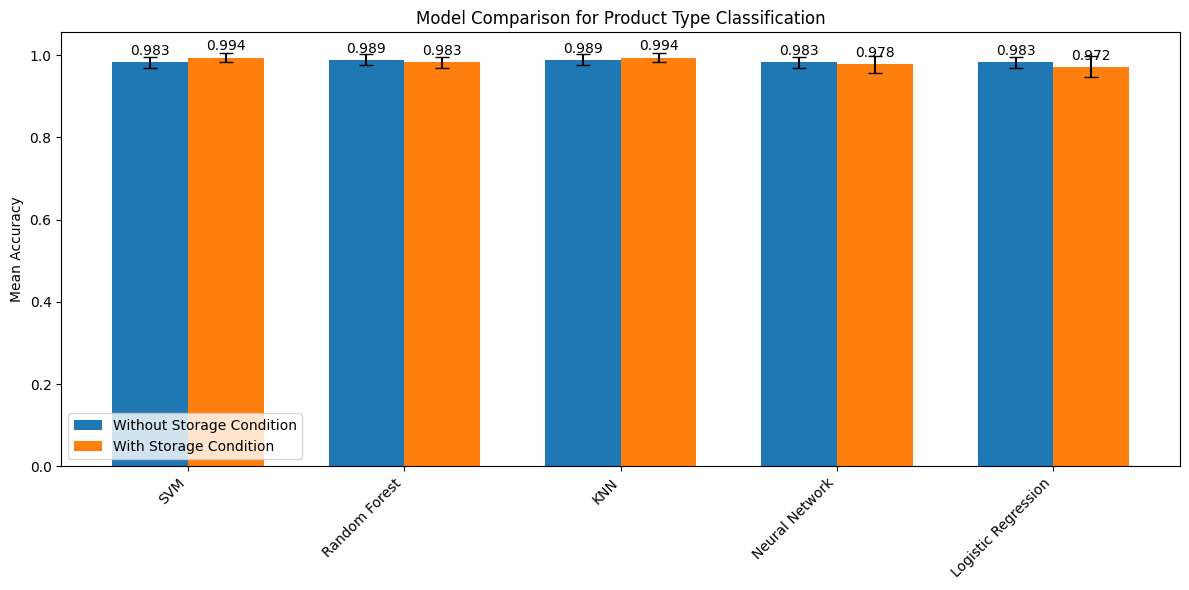


Performing ROC AUC analysis...

Calculating ROC AUC for SVM...
  ROC AUC Results:
  - Bread: 0.9999
  - Cookies: 0.9999
  - macro_avg: 0.9999

Calculating ROC AUC for Random Forest...
  ROC AUC Results:
  - Bread: 0.9969
  - Cookies: 0.9969
  - macro_avg: 0.9969

Calculating ROC AUC for KNN...
  ROC AUC Results:
  - Bread: 1.0000
  - Cookies: 1.0000
  - macro_avg: 1.0000

Calculating ROC AUC for Neural Network...
  ROC AUC Results:
  - Bread: 0.9993
  - Cookies: 0.9993
  - macro_avg: 0.9993

Calculating ROC AUC for Logistic Regression...
  ROC AUC Results:
  - Bread: 0.9874
  - Cookies: 0.9874
  - macro_avg: 0.9874

Calculating ROC AUC for SVM...
  ROC AUC Results:
  - Bread: 0.9864
  - Cookies: 0.9864
  - macro_avg: 0.9864

Calculating ROC AUC for Random Forest...
  ROC AUC Results:
  - Bread: 0.9965
  - Cookies: 0.9965
  - macro_avg: 0.9965

Calculating ROC AUC for KNN...
  ROC AUC Results:
  - Bread: 0.9996
  - Cookies: 0.9996
  - macro_avg: 0.9996

Calculating ROC AUC for Neural N

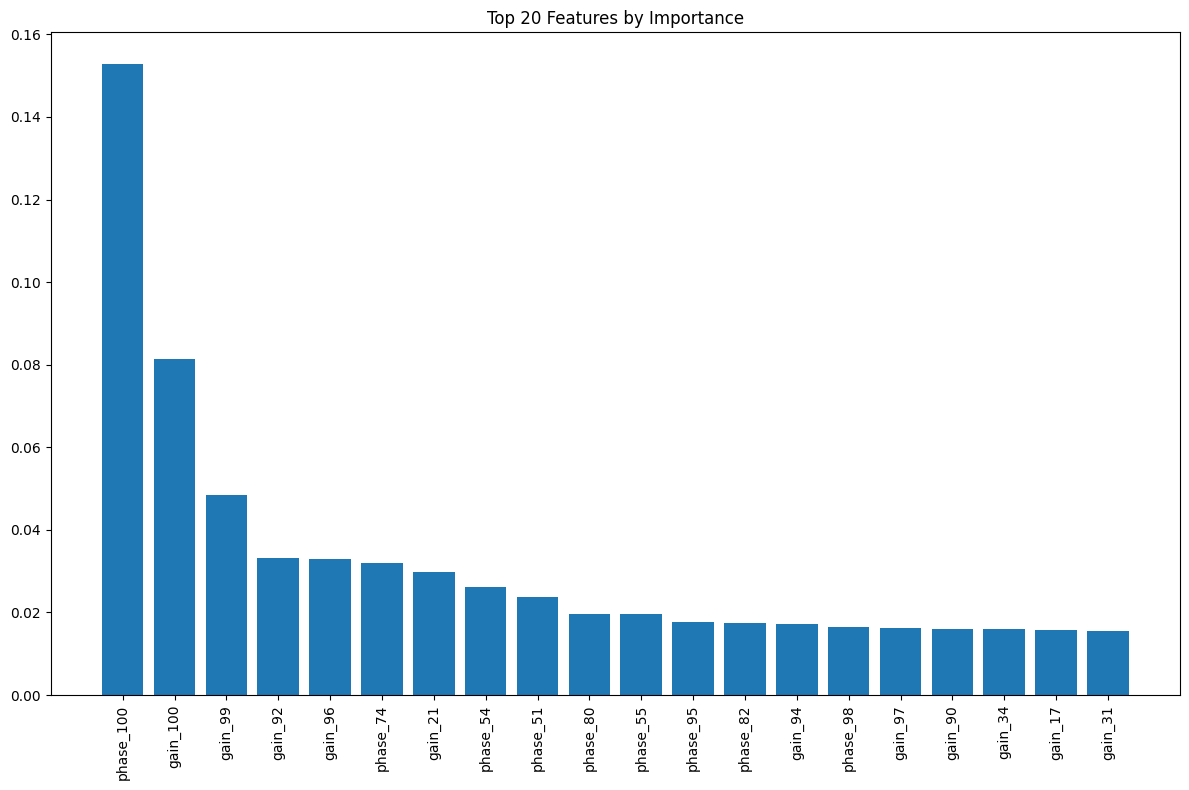


Top 10 most important features:
1. phase_100: 0.1529
2. gain_100: 0.0813
3. gain_99: 0.0484
4. gain_92: 0.0333
5. gain_96: 0.0328
6. phase_74: 0.0319
7. gain_21: 0.0297
8. phase_54: 0.0261
9. phase_51: 0.0238
10. phase_80: 0.0197

Statistical Analysis Results:

SVM:
- Without Storage Condition: 0.9833 ± 0.0136
- With Storage Condition: 0.9944 ± 0.0111
- Improvement: 1.11%
- Statistical Significance (p < 0.05): No (p = 0.1778)

Random Forest:
- Without Storage Condition: 0.9889 ± 0.0136
- With Storage Condition: 0.9833 ± 0.0136
- Improvement: -0.56%
- Statistical Significance (p < 0.05): No (p = 0.3739)

KNN:
- Without Storage Condition: 0.9889 ± 0.0136
- With Storage Condition: 0.9944 ± 0.0111
- Improvement: 0.56%
- Statistical Significance (p < 0.05): No (p = 0.3739)

Neural Network:
- Without Storage Condition: 0.9833 ± 0.0136
- With Storage Condition: 0.9778 ± 0.0208
- Improvement: -0.56%
- Statistical Significance (p < 0.05): No (p = 0.3739)

Logistic Regression:
- Without Storage

In [18]:
# Main Execution
if __name__ == "__main__":
    # 1. Prepare Data
    X_with_storage, X_without_storage, y_product, class_labels, feature_cols = prepare_data()
    
    # 2. Load Models
    print("Loading best parameters and creating models...")
    best_params = load_best_parameters()
    if best_params is None:
        print("Error: Could not load hyperparameter results. Exiting.")
        import sys
        sys.exit(1)
        
    models_with_storage = create_models(best_params, 'with_storage_condition')
    models_without_storage = create_models(best_params, 'without_storage_condition')
    
    # 3. Evaluate Models
    print("\nEvaluating models with storage condition...")
    results_with_storage = evaluate_models(X_with_storage, y_product, models_with_storage)
    
    print("\nEvaluating models without storage condition...")
    results_without_storage = evaluate_models(X_without_storage, y_product, models_without_storage)
    
    # 4. Generate Visualizations and Analysis
    print("\nGenerating visualizations and analysis...")
    
    # Model comparison plot
    plot_model_comparison(results_without_storage, results_with_storage)
    
    # Confusion matrices with actual class labels
    plot_confusion_matrices(results_without_storage, results_with_storage, class_labels)
    
    # ROC AUC Analysis
    print("\nPerforming ROC AUC analysis...")
    roc_results_with = evaluate_roc_auc(X_with_storage, y_product, models_with_storage, class_labels)
    roc_results_without = evaluate_roc_auc(X_without_storage, y_product, models_without_storage, class_labels)
    compare_roc_auc(roc_results_with, roc_results_without, class_labels)
    
    # Feature Importance Analysis
    print("\nAnalyzing feature importance...")
    if 'Random Forest' in models_with_storage:
        rf_model = models_with_storage['Random Forest']
        top_features = analyze_feature_importance(
            rf_model, X_with_storage, feature_cols, 
            top_n=20, include_storage=True
        )
        
        print("\nTop 10 most important features:")
        for i, (feature, importance) in enumerate(top_features[:10]):
            print(f"{i+1}. {feature}: {importance:.4f}")
    
    # Statistical analysis
    stats_results = perform_statistical_analysis(results_without_storage, results_with_storage)
    
    # Save analysis summary
    save_analysis_summary(results_without_storage, results_with_storage, 
                         stats_results, roc_results_with, roc_results_without)

    # Learning curves
    print("\nGenerating learning curves...")
    for model_name, model in models_with_storage.items():
        print(f"Generating learning curve for {model_name}...")
        plot_learning_curves(X_with_storage, y_product, model, model_name)
    
    print("\nAnalysis complete!")
    print(f"All results saved to: {RESULTS_DIR}")